In [1]:
# Standard libraries
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("figures.mplstyle")
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import shapely

# Function and class def|intions for defining LHC/Lake geometry
from GeometryHelpers import *

In [2]:
#LHC_data = pd.read_parquet('Data/LHC_data.parquet')
LHC_data = pd.read_parquet('Data/LHC_data_official.parquet')
Lake_data = pd.read_parquet('Data/Lake_data.parquet')

# Define the LHC circle
# using rough points
# LHC = Circle(np.array(LHC_data.loc['Point4',['X','Y','Z']]),
#              np.array(LHC_data.loc['LHCb',['X','Y','Z']]),
#              np.array(LHC_data.loc['Point6',['X','Y','Z']])) # last entry can be Point 2 or 6
# using official points
LHC = Circle(np.array(LHC_data.loc['ATLAS',['X','Y','Z']]),
             np.array(LHC_data.loc['CMS',['X','Y','Z']]),
             np.array(LHC_data.loc['LHCb',['X','Y','Z']])) # last entry can be Point 2 or 6
print(LHC.radius,2*np.pi*LHC.radius)

# Fix elevation of other LHC interaction points based on LHC circle definition
for k in list(LHC_data.index):
    elev,point = LHC.find_elevation(*np.array(LHC_data.loc[k,['Latitude','Longitude']]))
    LHC_data['Elevation'][k] = elev
    LHC_data.loc[k,['X','Y','Z']] = lat_long_to_xyz(*LHC_data.loc[k,['Latitude','Longitude','Elevation']])
print(LHC_data)

4205.647772848721 26424.864293535633
         Latitude  Longitude   Elevation  SurfaceElevation             X  \
ATLAS   46.235709   6.055279  409.004000             440.9  4.382472e+06   
ALICE   46.251529   6.021616  453.640649             448.0  4.381511e+06   
Point3  46.277530   6.012180  489.103562             536.4  4.379534e+06   
Point4  46.304431   6.036295  497.791432             585.9  4.377195e+06   
CMS     46.309895   6.076612  470.307000             510.0  4.376412e+06   
Point6  46.293460   6.111853  423.711221             471.0  4.377407e+06   
Point7  46.266426   6.114851  392.209269             433.2  4.379521e+06   
LHCb    46.241397   6.096324  381.112000             426.6  4.381664e+06   

                    Y             Z  CrossingOrientation  CrossingAngle  
ATLAS   464891.672130  4.601377e+06                  0.0        0.00028  
ALICE   462186.728824  4.602626e+06                  0.0        0.00040  
Point3  461248.855836  4.604651e+06                  NaN

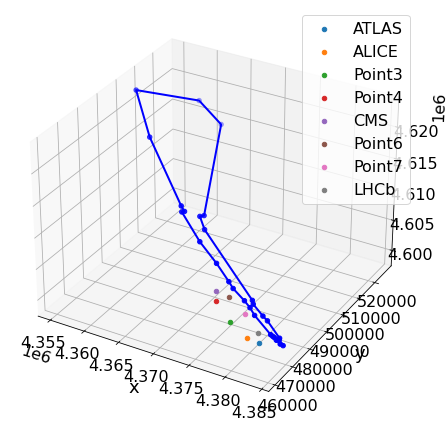

In [3]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
for k in list(LHC_data.index):
    ax.scatter(*LHC_data.loc[k,['X','Y','Z']])
ax.scatter(*np.array(Lake_data[['X','Y','Z']]).transpose(),color='blue')
# for point in Lake_data[['X','Y','Z']]:
#     ax.scatter(*point,color='blue')
ax.plot(np.append(Lake_data['X'],Lake_data['X'][0]),
        np.append(Lake_data['Y'],Lake_data['Y'][0]),
        zs=np.append(Lake_data['Z'],Lake_data['Z'][0]),
        color='blue')
plt.legend(list(LHC_data.index))
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

[ 46.24139729   6.09632353 381.112     ]
[  45.73591448    5.02607175 1526.07449827] [ 46.73676458   7.18640112 805.55090474]
1.1369489530231651


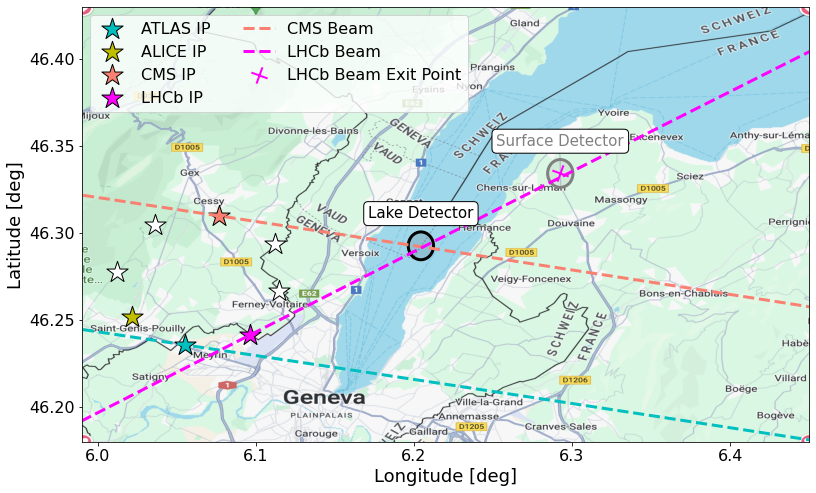

In [4]:
lat_edges = [46.18,46.43]
lon_edges = [5.99,6.45]
# lat_edges = [46,46.8]
# lon_edges = [5.2,7.3]
aspect_ratio = (lon_edges[1]-lon_edges[0])/(lat_edges[1]-lat_edges[0])
fig_height=8

fig = plt.figure(figsize=(aspect_ratio*fig_height,fig_height))
ax = plt.gca()
#ax.set_facecolor((0,1,0,0.2))

# plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
#          list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
#          color='blue',alpha=0.4,linewidth=2)
Lake_Crossings = {}
color_count = 0
colors = ["c","y","salmon","fuchsia"]
color_dict = {}
for k in list(LHC_data.index):
    if "Point" in k: color = "white"
    else:
        color = colors[color_count]
        color_dict[k] = color
        color_count+=1
    Lake_Crossings[k] = []
    limit = 1
    if k=="LHCb": limit = 100000#180000
    elif k=="CMS": limit = 400000
    elif k=="ATLAS": limit = 400000 
    lines = plot_tangent_line_lat_long(LHC,
                                       np.array(LHC_data.loc[k,['X','Y','Z']]),
                                       np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                       limit=limit)
    center, earth_points = lines[0] # all lines are essentially the same
    if k=="LHCb":
        print(center)
        print(earth_points[0],earth_points[-1])
        delta = earth_points[-1][:2] - earth_points[0][:2]
        delta /= np.linalg.norm(delta)
        print(np.arctan(delta[1]/delta[0]))
    plt.scatter(center[1],
                center[0],
                marker='*',s=500,facecolor=color,edgecolor="black",label=k+" IP" if not "Point" in k else None)
    plt.plot([p[1] for p in earth_points],
             [p[0] for p in earth_points],color=color,ls='--',lw=3,label="%s Beam"%k if k in ["LHCb","CMS"] else None)
    if 'Point' in k: continue # don't consider points without collisions
    #if k!="ATLAS": continue
    int1,int2 = calculate_intersections_with_lake(LHC,
                                                np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                np.array(Lake_data[['Latitude','Longitude']]),
                                                limit=50000000)
    for intersections in (int1,int2):
        if(type(intersections) == shapely.geometry.MultiLineString):
            for intersection in intersections.geoms:
                for coord in list(intersection.coords):
                    Lake_Crossings[k].append(coord)
        else:
            for coord in list(intersections.coords):
                Lake_Crossings[k].append(coord)

# Pipe detector
pts = np.array([[6.19,46.281],[6.185,46.2889],[6.225,46.3075],[6.2305,46.3]])
pipe_center = (6.2044197,46.29265435)
circle = plt.Circle(pipe_center,0.008,ec="black",facecolor=mcolors.to_rgba('black', 0.1),lw=3)
plt.gca().add_patch(circle)
plt.text(pipe_center[0],1.0004*pipe_center[1],"Lake Detector",ha="center",va="center",fontsize=15,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
# rectangle = Polygon(pts,edgecolor="black",facecolor=mcolors.to_rgba('black', 0.1),lw=3)
# plt.gca().add_patch(rectangle)
# plt.text(6.17,46.293,"Pipe Detector",fontsize=15,rotation=26.5,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


# Panel detector
beam_exit = (6.292559636631747,46.33426874901515)
circle = plt.Circle(beam_exit,0.008,ec="grey",facecolor=mcolors.to_rgba('grey', 0.1),lw=3)
plt.text(beam_exit[0],1.0004*beam_exit[1],"Surface Detector",color="grey",ha="center",va="center",fontsize=15,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
plt.gca().add_patch(circle)


t = matplotlib.markers.MarkerStyle(marker="+")
t._transform = t.get_transform().rotate_deg(-20)
plt.scatter(*beam_exit,marker=t,facecolors=colors[-1],s=300,label="LHCb Beam Exit Point")


img = plt.imread("Figures/GoogleMaps.png")
plt.imshow(img,extent=[lon_edges[0],lon_edges[1],lat_edges[0],lat_edges[1]],aspect=1.1)
plt.xlim(*lon_edges)
plt.ylim(*lat_edges)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,4,3,5,6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='upper left',ncol=2)


plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/Nu2024_Poster/GeometryDiagram.pdf",dpi=100)
plt.show()

3816.1599999999976
LHCb interaction point: 98.3070000000298


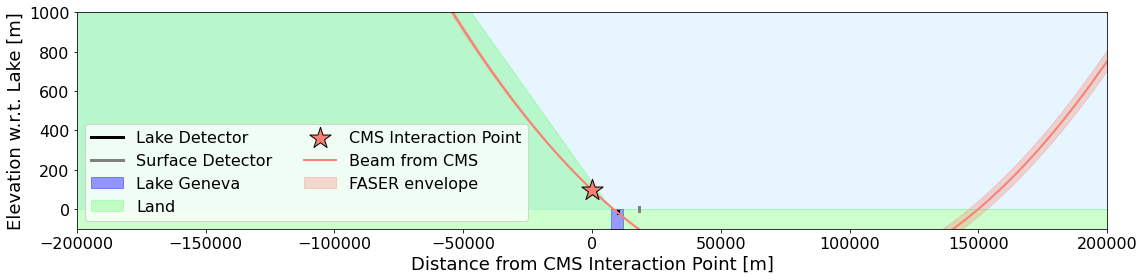

1636.4173913043512
LHCb interaction point: 9.112000000663102


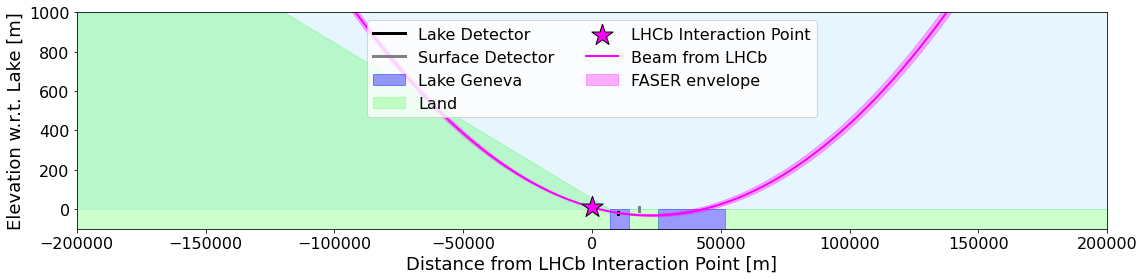

0
LHCb interaction point: 37.00399999972433


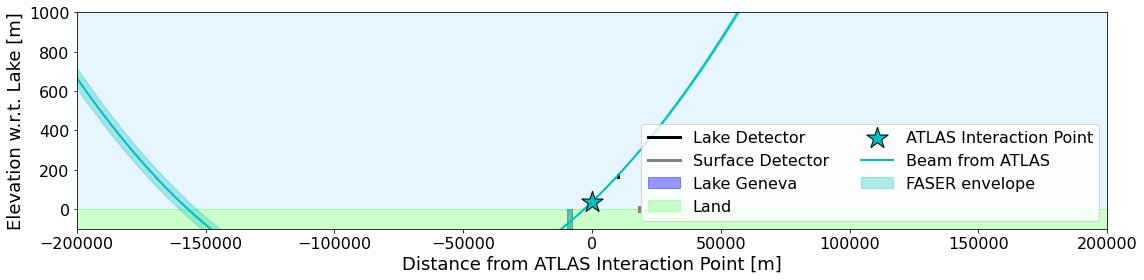

In [5]:
# elevation plot
    
k = "LHCb"
for k in ["CMS","LHCb","ATLAS"]:
    fig = plt.figure()
    fig.set_size_inches(16,4)
    plot_tangent_elevation(fig,
                           LHC,
                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                           #[0,2000e-6],
                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                           limit=200000,
                           Lake_Crossings=Lake_Crossings[k],
                           IPlabel=k,
                           color=color_dict[k],
                           #pipe_position=14602,
                           #panel_position=14700,
                           flip=k=="CMS",
                           y0=LHC_data.loc[k,"SurfaceElevation"])
    if k=="LHCb":
        plt.xlim(-200000,200000)
        plt.ylim(-100,1000)
    if k=="CMS": 
        plt.xlim(-200000,200000)
        plt.ylim(-100,1000)
    if k=="ATLAS": 
        plt.xlim(-200000,200000)
        plt.ylim(-100,1000)
    #plt.xlim(14200,15000)
    plt.gcf().patch.set_alpha(0.0)
    plt.tight_layout()
    plt.savefig("Figures/Nu2024_Poster/%s_ElevationDiagram_Correlated.pdf"%k,dpi=100)
    plt.show()

Detector lat/long/elevation: [ 46.29117444   6.20395559 353.02062779]
(6853.4267133566755, 14357.17858929465)
(25462.73136568285, 51775.88794397199)


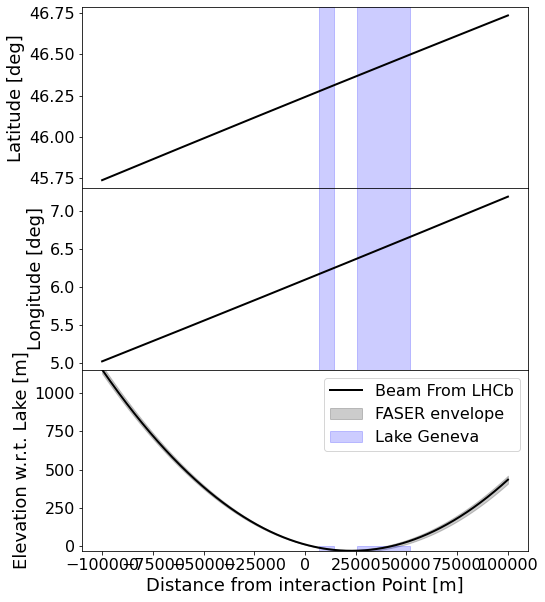

Detector lat/long/elevation: [ 46.3273827    5.94950358 601.72412822]
(-7553.776888444219, -11955.977988994491)


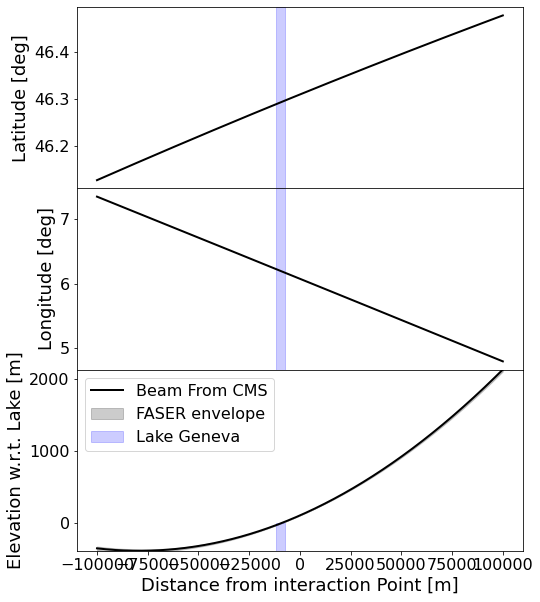

Detector lat/long/elevation: [ 46.25296655   5.9282757  540.25031043]
(-7653.826913456724, -9654.827413706851)


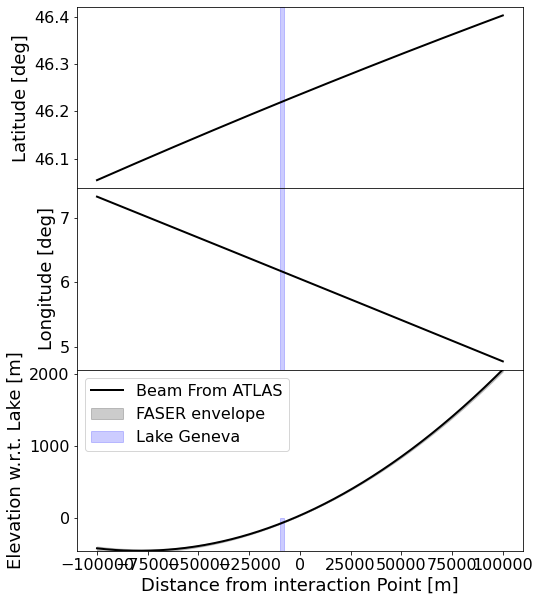

Detector lat/long/elevation: [ 46.3685101    6.04120607 569.68755927]


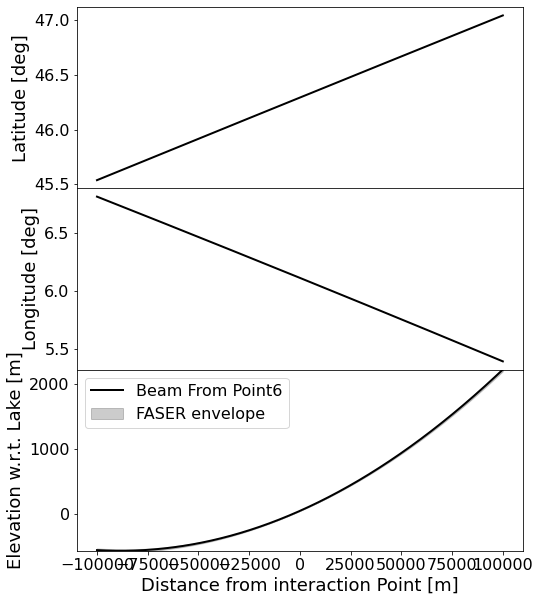

In [6]:
for k in ['LHCb','CMS','ATLAS','Point6']:
    plot_tangent_line(LHC,
                      np.array(LHC_data.loc[k,['X','Y','Z']]),
                      np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                      limit=100000,
                      Lake_Crossings=Lake_Crossings[k],
                      label='Beam From %s'%k)
    plt.show()

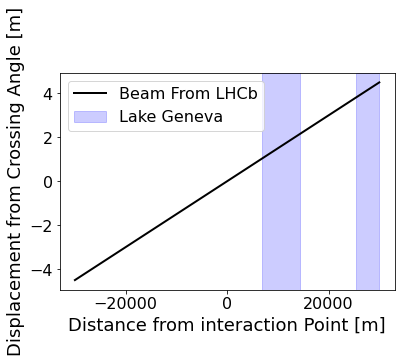

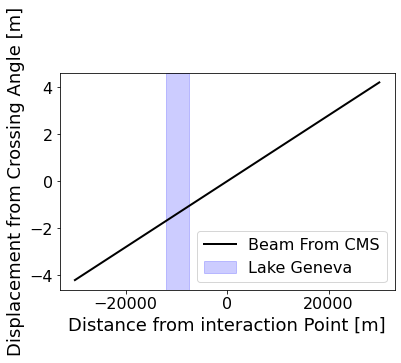

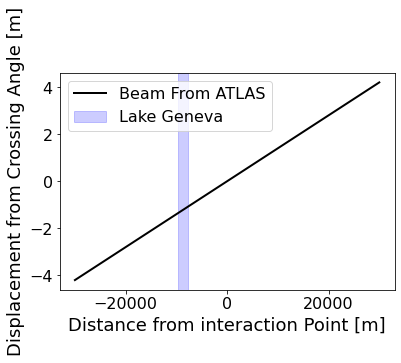

In [7]:
for k in ['LHCb','CMS','ATLAS']:
    plot_crossing_angle_impact(LHC,
                               np.array(LHC_data.loc[k,['X','Y','Z']]),
                               np.array(LHC_data.loc[k,['CrossingAngle']])/2.,
                               limit=30000,
                               Lake_Crossings=Lake_Crossings[k],
                               label='Beam From %s'%k)
    plt.show()

# Siren file calculations

In [8]:
LHCb_depth = 34.97 #m
water_depth = 50
water_crossings = [6873.44,
                   14617.31] #m along beamline
surface_crossing = 18210.36
theta = np.arccos(LHCb_depth/surface_crossing)
print(water_crossings[0]*np.sin(theta))
print(water_crossings[1]*np.sin(theta))
print(surface_crossing*np.sin(theta))

6873.427326436288
14617.283047933846
18210.326422903574


In [9]:
water_length = (water_crossings[1] - water_crossings[0]) * np.sin(theta)
print("water length:",water_length)
water_center = water_crossings[0]*np.sin(theta) + water_length/2
print("water center:",water_center)

water length: 7743.855721497559
water center: 10745.355187185069


In [10]:
h_scint = [1,3,5,2.59,2.59*3]
for h in h_scint:
    xs = h/2*np.tan(theta)
    print(h,surface_crossing+xs)

1 18470.730695208782
3 18991.472085626345
5 19512.213476043908
2.59 18884.720100590745
7.77 20233.440301772232


In [11]:
beam_depth_at_water_center = LHCb_depth - ((water_center)*np.sin(theta)/np.tan(theta))
print(beam_depth_at_water_center)

14.335313431700946


In [12]:
2.59/2

1.295

# Official geometry calculations

Based on:

<img src="Figures/official_coordinates.png" alt="drawing" width="600"/>
<img src="Figures/official_coordinates_lhcb.png" alt="drawing" width="600"/>


In [13]:
def minsec_to_dec(first_digit,minutes,seconds):
    return first_digit + minutes/60 + seconds/(60*60)

surface_exits = {"LHCb_South":np.array([minsec_to_dec(46,7,6.6649),minsec_to_dec(5,49,55.4673),516.80]),
                 "LHCb_North":np.array([minsec_to_dec(46,44,24.8500),minsec_to_dec(7,11,44.0499),766.64]),
                 "CMS_West":np.array([minsec_to_dec(46,20,32.9799),minsec_to_dec(5,50,19.7639),678.74]),
                 "CMS_East":np.array([minsec_to_dec(45,59,59.5943),minsec_to_dec(8,10,8.1070),508.31]),
                 "ATLAS_West":np.array([minsec_to_dec(46,16,56.7102),minsec_to_dec(5,42,48.0509),748.53]),
                 "ATLAS_East":np.array([minsec_to_dec(45,59,59.5943),minsec_to_dec(8,10,8.1070),717.94])}

lake_intersections = {"LHCb_1":np.array([minsec_to_dec(46,22,15.2013),minsec_to_dec(6,22,39.0901),372-82]),
                      "LHCb_2":np.array([minsec_to_dec(46,30,12.1910),minsec_to_dec(6,40,05.5942),372-13.3])}


LHCb_dir = lat_long_to_xyz(*surface_exits["LHCb_North"]) - lat_long_to_xyz(*surface_exits["LHCb_South"])
LHCb_dist = np.linalg.norm(LHCb_dir)
LHCb_dir /= LHCb_dist

LHCb_dir_official = LHC.tangent_line(np.array(LHC_data.loc['LHCb',['X','Y','Z']]),np.array(LHC_data.loc['LHCb',['CrossingOrientation','CrossingAngle']]))
print(np.arccos(np.dot(LHCb_dir,LHCb_dir_official[0]))*1e6)

683.6885864969612


In [14]:
# angle of beams exiting surface
for kse,se in surface_exits.items():
    surface_loc = np.array(lat_long_to_xyz(*se))
    IP_loc = None
    for k in list(LHC_data.index):
        if k in kse:
            IP_loc = np.array(LHC_data.loc[k,['X','Y','Z']])
    assert(IP_loc is not None)
    surface_normal_dir = surface_loc / np.linalg.norm(surface_loc)
    beam_exit_displacement = surface_loc - IP_loc
    beam_surface_distance = np.linalg.norm(beam_exit_displacement)
    beam_exit_dir = beam_exit_displacement / beam_surface_distance
    angle = np.pi/2 - np.arccos(np.dot(beam_exit_dir,surface_normal_dir))
    print("%s: %2.1f km from IP, exits at %2.2f deg w.r.t. surface at elevation of %2.2f m"%(kse,beam_surface_distance/1e3,(180/np.pi)*angle,se[-1]))

LHCb_South: 24.5 km from IP, exits at 0.43 deg w.r.t. surface at elevation of 516.80 m
LHCb_North: 100.8 km from IP, exits at 0.67 deg w.r.t. surface at elevation of 766.64 m
CMS_West: 18.6 km from IP, exits at 0.73 deg w.r.t. surface at elevation of 678.74 m
CMS_East: 164.8 km from IP, exits at 0.75 deg w.r.t. surface at elevation of 508.31 m
ATLAS_West: 26.8 km from IP, exits at 0.85 deg w.r.t. surface at elevation of 748.53 m
ATLAS_East: 165.0 km from IP, exits at 0.85 deg w.r.t. surface at elevation of 717.94 m


In [15]:
dist = 0
loc = np.array(lat_long_to_xyz(*surface_exits["LHCb_North"]))
N = 10000
LHCb_loc = np.array([minsec_to_dec(46,14,29.0302344), minsec_to_dec(6,5,46.7646927)])
LHCb_lake_1 = np.array([minsec_to_dec(46,22,15.2013),minsec_to_dec(6,22,39.0901)])
LHCb_lake_2 = np.array([minsec_to_dec(46,30,12.1910),minsec_to_dec(6,40,05.5942)])
print(LHCb_lake_1)
print(LHCb_lake_2)
locations = {'IP':LHCb_loc,
          'lake1':LHCb_lake_1,
          'lake2':LHCb_lake_2}
min_errors = {'IP':np.inf,
          'lake1':np.inf,
          'lake2':np.inf}
positions = {'IP':None,
             'lake1':None,
             'lake2':None}
while dist < LHCb_dist:
    #print(loc,dist)
    lat,long,elev = xyz_to_lat_long(*loc)
    dist += (LHCb_dist/N)
    loc -= (LHCb_dist/N)*LHCb_dir_official[0]
    for k,v in min_errors.items():
        error = np.linalg.norm(np.array([lat,long]) - locations[k])
        if error < v:
            positions[k] = [lat,long,elev]
            min_errors[k] = error
    
for k,v in positions.items():
    print(k,v[0],v[1],v[2],v[2]-372)

[46.37088925  6.37752503]
[46.50338639  6.66822061]
IP 46.240908478936504 6.096603992876999 332.5704509858042 -39.4295490141958
lake1 46.37051892807314 6.3777269677781305 291.8731118440628 -80.1268881559372
lake2 46.5031594489155 6.668381703439524 360.4375361977145 -11.562463802285492


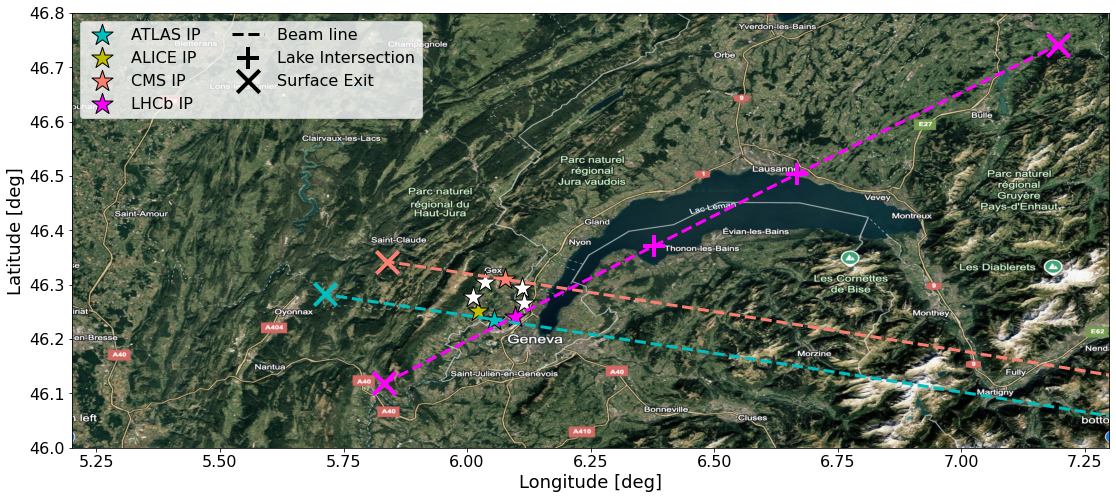

In [16]:
lat_edges = [46,46.8]
lon_edges = [5.2,7.3]
aspect_ratio = (lon_edges[1]-lon_edges[0])/(lat_edges[1]-lat_edges[0])
fig_height=8

fig = plt.figure(figsize=(aspect_ratio*fig_height,fig_height))
ax = plt.gca()

Lake_Crossings = {}
color_count = 0
colors = ["c","y","salmon","fuchsia"]
color_dict = {}
for k in list(LHC_data.index):
    if "Point" in k: color = "white"
    else:
        color = colors[color_count]
        color_dict[k] = color
        color_count+=1
    Lake_Crossings[k] = []
    limit = 1
    if k=="LHCb": limit = [-np.linalg.norm(lat_long_to_xyz(*surface_exits["LHCb_South"]) - np.array(LHC_data.loc['LHCb',['X','Y','Z']])),
                           np.linalg.norm(lat_long_to_xyz(*surface_exits["LHCb_North"]) - np.array(LHC_data.loc['LHCb',['X','Y','Z']]))]
    elif k=="CMS": limit = [-np.linalg.norm(lat_long_to_xyz(*surface_exits["CMS_East"]) - np.array(LHC_data.loc['CMS',['X','Y','Z']])),
                           np.linalg.norm(lat_long_to_xyz(*surface_exits["CMS_West"]) - np.array(LHC_data.loc['CMS',['X','Y','Z']]))]
    elif k=="ATLAS": limit = [-np.linalg.norm(lat_long_to_xyz(*surface_exits["ATLAS_East"]) - np.array(LHC_data.loc['ATLAS',['X','Y','Z']])),
                           np.linalg.norm(lat_long_to_xyz(*surface_exits["ATLAS_West"]) - np.array(LHC_data.loc['ATLAS',['X','Y','Z']]))]
    lines = plot_tangent_line_lat_long(LHC,
                                       np.array(LHC_data.loc[k,['X','Y','Z']]),
                                       np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                       limit=limit)
    center, earth_points = lines[0] # all lines are essentially the same
    lat,long,_ = xyz_to_lat_long(*np.array(LHC_data.loc[k,['X','Y','Z']]))
    plt.scatter(long,lat,marker='*',s=500,facecolor=color,edgecolor="black",label=k+" IP" if not "Point" in k else None)
    plt.plot([p[1] for p in earth_points],
             [p[0] for p in earth_points],color=color,ls='--',lw=3,label="%s Beam"%k if k in [] else None)
    
    for kse,surface_exit in surface_exits.items():
        if k in kse:
            plt.scatter(surface_exit[1],surface_exit[0],marker='x',linewidths=4,s=500,facecolor=color)
    for kle,lake_int in lake_intersections.items():
        if k in kle:
            plt.scatter(lake_int[1],lake_int[0],marker='+',linewidths=4,s=500,facecolor=color)

plt.plot([],[],ls='--',lw=3,color="black",label="Beam line")
plt.scatter([],[],marker='+',linewidths=4,s=500,facecolor="black",label="Lake Intersection")
plt.scatter([],[],marker='x',linewidths=4,s=500,facecolor="black",label="Surface Exit")

img = plt.imread("Figures/GoogleEarth.png")
plt.imshow(img,extent=[lon_edges[0],lon_edges[1],lat_edges[0],lat_edges[1]],aspect=1.1)
plt.xlim(*lon_edges)
plt.ylim(*lat_edges)
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5,6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='upper left',ncol=2)


plt.gcf().patch.set_alpha(0.0)
plt.savefig("Figures/Nu2024_Poster/GeometryDiagramLarge.pdf",dpi=100)
plt.show()

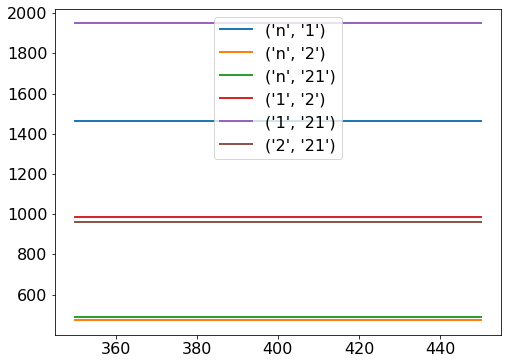

In [17]:
LHCb_loc = np.array(LHC_data.loc['LHCb',['X','Y','Z']])

def get_directions(lake_height):
    dirs = {}
    dirs['s'] = LHCb_loc - lat_long_to_xyz(*surface_exits["LHCb_South"])
    dirs['s'] /= np.linalg.norm(dirs['s'])
    dirs['n'] = lat_long_to_xyz(*surface_exits["LHCb_North"]) - LHCb_loc
    dirs['n'] /= np.linalg.norm(dirs['n'])
    dirs['1'] = lat_long_to_xyz(*lake_intersections["LHCb_1"]) - LHCb_loc
    dirs['1'] /= np.linalg.norm(dirs['1'])
    dirs['2'] = lat_long_to_xyz(*lake_intersections["LHCb_2"]) - LHCb_loc
    dirs['2'] /= np.linalg.norm(dirs['2'])
    dirs['21']  = lat_long_to_xyz(*lake_intersections["LHCb_2"]) - lat_long_to_xyz(*lake_intersections["LHCb_1"])
    dirs['21']  /= np.linalg.norm(dirs['21'])
    return dirs

def get_dir_alignments(dirs):
    dir_alignment = {}
    for k1,v1 in dirs.items():
        for k2,v2 in dirs.items():
            if k1==k2: continue
            if (k2,k1) in dir_alignment.keys(): continue

            dir_alignment[(k1,k2)] = (1e6*np.arccos(np.dot(v1,v2)))
    return dir_alignment

dir_alignment = {}
lake_heights = np.linspace(350,450,2)
for lake_height in lake_heights:
    dirs = get_directions(lake_height)
    for k1,v1 in dirs.items():
        for k2,v2 in dirs.items():
            if k1==k2: continue
            if (k2,k1) in dir_alignment.keys(): continue
            if k1=='s' or k2=='s': continue
            if (k1,k2) not in dir_alignment.keys():
                dir_alignment[(k1,k2)] = []
            
            dir_alignment[(k1,k2)].append(1e6*np.arccos(np.dot(v1,v2)))

for k,v in dir_alignment.items():
    plt.plot(lake_heights,v,label=k)
plt.legend()
    